## CSV to midi

### Setup

In [1]:
import pandas as pd
import numpy as np
import pretty_midi
# import fluidsynth
# from IPython import display
from IPython.display import Image, Audio
import glob
import collections
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

In [2]:
filenames = glob.glob('../raw_data/mozart_sonatas/mps - K*')
print('Number of files:', len(filenames))
print('first file:', filenames[0])

Number of files: 57
first file: ../raw_data/mozart_sonatas/mps - K311-I.csv


**create pieces df (each row is one piece)**

In [3]:
pieces_df = pd.read_csv('../raw_data/mozart_sonatas/mps - pieces.csv')
pieces_df.head()

,name,key,title,time_sig,tempo marking,bpm,pickup_bar,pickup_length
0,K545-I,c major,NaN,common,allegro,4=132,0,0
1,K545-II,g major,NaN,3/4,andante,4=60,0,0
2,K545-III,c major,Rondo,2/4,allegretto grazioso,4=104,1,4
3,K283-I,g major,NaN,3/4,allegro,4=138,1,4
4,K283-II,c major,NaN,common,andante,4=58,0,0


### Normalize pitches to C major / A minor

**create key converter dictionaries**

In [4]:
all_keys = set([key for key in pieces_df.key.value_counts().index])
all_keys

{'a major',
 'a minor',
 'bb major',
 'c major',
 'c minor',
 'd major',
 'eb major',
 'f major',
 'f minor',
 'g major'}

In [5]:
# key: # of half steps to add to get to c major / a minor
maj_key_converter_dict = {'a major': 3, 'bb major': 2, 'c major': 0, 'd major': -2, 'eb major': -3, 'f major': -5, 'g major': 5}
min_key_converter_dict = {'a minor': 0, 'c minor': -3, 'f minor': 4}

In [6]:
def normalize_pitches(x, piece_key_type, piece_key):
    if x > 0:
        if piece_key_type == 'major':
            x += maj_key_converter_dict[piece_key]
        else:
            x += min_key_converter_dict[piece_key]
    return x

### Create duration (in seconds) column

In [7]:
bpm_beat_types = set([bpm.split('=')[0] for bpm in pieces_df.bpm.value_counts().index])
bpm_beat_types

{'2', '2d', '4', '4d', '8'}

In [8]:
# bpm note value: amount to multiply bpm by to convert bpm to quarter notes
bpm_converter_dict = {'2': 2, '2d': 3, '4': 1, '4d': 1.5, '8': 0.5}

In [9]:
# duration: amount to multiply spb (seconds per beat) by to get duration in seconds
beat_dict = {
    '1': 4, 
    '2': 2, 
    '4': 1, 
    '8': 0.5,
    '16': 0.25,
    '32': 0.125,
    '64': 0.0625
}

In [10]:
def duration_to_seconds(x, piece_spb):
    if type(x) != 'str':
        x = str(x)
    if x[-2:] == 'dd':
        s = piece_spb * beat_dict[x[:-2]] * 1.75
    elif x[-1] == 'd':
        s = piece_spb * beat_dict[x[:-1]] * 1.5
    else:
        s = piece_spb * beat_dict[x]
    return s

### preprocess all dfs

In [12]:
def process_df(filename):
    
    # extract the K number
    k_num = filename.split(' - ')[1].split('.csv')[0].strip(' ')
    
    # create df
    df = pd.read_csv(filename)  # make df
    
    # normalize pitch
    df['pitch'] = df.note_name.apply(lambda x: pretty_midi.note_name_to_number(x) if x != 'r' else 0)  
    piece_key = pieces_df[pieces_df['name'] == k_num]['key'].values[0].strip(' ')
    piece_key_type = piece_key.split(' ')[1].strip(' ')
    df['pitch_norm'] = df.pitch.apply(normalize_pitches, args=(piece_key_type, piece_key))
    
    # get duration in seconds
    piece_bpm = pieces_df[pieces_df['name'] == k_num]['bpm'].values[0].split('=')
    piece_bpm_norm = int(bpm_converter_dict[piece_bpm[0]] * int(piece_bpm[1]))
    piece_spb = 60 / piece_bpm_norm
    df['dur(s)'] = df.duration.apply(duration_to_seconds, args=(piece_spb,))
    
    return df

In [13]:
all_csv_dfs = []
for file in filenames:
    all_csv_dfs.append(process_df(file))

In [14]:
all_csv_dfs[0].head()

,note_name,duration,measure,beat,subdiv,harm,from_root,NCT,BI2,CI,trill,dynamic,pitch,pitch_norm,dur(s)
0,d5,4,1,1,1,I,1,0,0,0,0,f,74,72,0.454545
1,r,4,1,2,1,0,0,0,0,0,0,f,0,0,0.454545
2,g5,16,1,3,1,I,4,1,0,0,0,f,79,77,0.113636
3,f#5,16,1,3,2,I,3,0,0,0,0,f,78,76,0.113636
4,e5,16,1,3,3,I,2,1,0,0,0,f,76,74,0.113636


### Using categorical target

In [15]:
# make columns of each pitch-duration pair transposed to 12 keys

for df in all_csv_dfs:
    for i in range(-6, 6):
        pitch_duration = []
        for ind, val in df.iterrows():
            if val.note_name == 'r':
                pitch_duration.append(str(0) + '-' + str(val.duration))
            else:
                pitch_duration.append(str(int(val.pitch_norm + i)) + '-' + str(val.duration))
        df[f'pitch_dur{i}'] = pitch_duration

In [16]:
all_csv_dfs[0].head()

,note_name,duration,measure,beat,subdiv,harm,from_root,NCT,BI2,CI,...,pitch_dur-4,pitch_dur-3,pitch_dur-2,pitch_dur-1,pitch_dur0,pitch_dur1,pitch_dur2,pitch_dur3,pitch_dur4,pitch_dur5
0,d5,4,1,1,1,I,1,0,0,0,...,68-4,69-4,70-4,71-4,72-4,73-4,74-4,75-4,76-4,77-4
1,r,4,1,2,1,0,0,0,0,0,...,0-4,0-4,0-4,0-4,0-4,0-4,0-4,0-4,0-4,0-4
2,g5,16,1,3,1,I,4,1,0,0,...,73-16,74-16,75-16,76-16,77-16,78-16,79-16,80-16,81-16,82-16
3,f#5,16,1,3,2,I,3,0,0,0,...,72-16,73-16,74-16,75-16,76-16,77-16,78-16,79-16,80-16,81-16
4,e5,16,1,3,3,I,2,1,0,0,...,70-16,71-16,72-16,73-16,74-16,75-16,76-16,77-16,78-16,79-16


**creating clean csvs for api**

In [17]:
# removing pieces with pickup bars or complex meters
starter_dfs = []
for df in all_csv_dfs:
    subdiv_nums = df.subdiv.apply(lambda x: str(x)[0])
    if df.measure[0] in ['0', 0] or int(max(subdiv_nums)) > 4:
        continue
    starter_dfs.append(df)

len(starter_dfs)

33

In [19]:
for i, df in enumerate(starter_dfs):
    df.to_csv(f"../raw_data/clean_csvs/csv_{i}.csv")

**cont.**

In [108]:
all_csv_dfs[0].columns[15:27]

Index(['pitch_dur-6', 'pitch_dur-5', 'pitch_dur-4', 'pitch_dur-3',
       'pitch_dur-2', 'pitch_dur-1', 'pitch_dur0', 'pitch_dur1', 'pitch_dur2',
       'pitch_dur3', 'pitch_dur4', 'pitch_dur5'],
      dtype='object')

In [123]:
# Create mapping of all pitch_dur columns

corpus = []
list(all_csv_dfs[0]['pitch_dur-4']) + list(all_csv_dfs[0]['pitch_dur-3'])
for df in all_csv_dfs:
    for i in range(-6,6):
        pitch_dur = list(df[f'pitch_dur{i}'])
        corpus = corpus + pitch_dur        

In [126]:
count_num = collections.Counter(corpus)
print("Total notes in dataset:", len(corpus))
print("Total unique note / duration pairs in corpus:", len(count_num))

Total notes in dataset: 16368
Total unique note / duration pairs in corpus: 380


In [127]:
# Exploring the notes dictionary
Notes = list(count_num.keys())
Recurrence = list(count_num.values())

# Average recurrence for a note in Corpus
def Average(lst):
    return sum(lst) / len(lst)
print("Average recurrence for a note in Corpus:", Average(Recurrence))
print("Most frequent note in Corpus appeared:", max(Recurrence), "times")
print("Least frequent note in Corpus appeared:", min(Recurrence), "time")

Average recurrence for a note in Corpus: 43.07368421052632
Most frequent note in Corpus appeared: 480 times
Least frequent note in Corpus appeared: 1 time


In [128]:
# Storing all the unique characters present in the corpus to buid a mapping dict.
symb = sorted(list(set(corpus)))

L_corpus = len(corpus)  # length of corpus
L_symb = len(symb)  # length of total unique characters

# Building dictionary to access the vocabulary from indices and vice versa
mapping = dict((c, i) for i, c in enumerate(symb))
reverse_mapping = dict((i, c) for i, c in enumerate(symb))

print("Total number of characters:", L_corpus)
print("Number of unique characters:", L_symb)

Total number of characters: 16368
Number of unique characters: 380


In [132]:
# Splitting the corpus in equal length of strings and output target
length = 10
features = []
targets = []
for df in all_csv_dfs:
    # make embedded list of pitch_dur columns
    pitch_dur_columns = []
    for i in range(-6,6):
        pitch_dur_columns.append(list(df[f'pitch_dur{i}']))
    # add create features of length 10 and targets
    L_df = len(df)
    for column in pitch_dur_columns:    
        for i in range(0, L_df - length, 1):
            feature = column[i:i + length]
            target = column[i + length]
            features.append([mapping[j] for j in feature])
            targets.append(mapping[target])
    
L_datapoints = len(targets)
print("Total number of sequences in the corpus:", L_datapoints)

Total number of sequences in the corpus: 9528


In [135]:
# reshape X and normalize
X = (np.reshape(features, (L_datapoints, length, 1)))/ float(L_symb)
# one hot encode the output variable
y = to_categorical(targets)

In [180]:
y_vals = np.eye(y_counts.shape[0])

In [183]:
class_weights = {y_val: (1/count) * (len(y)/2) for (y_val, count) in zip(y_vals, y_counts)}

TypeError: unhashable type: 'numpy.ndarray'

In [169]:
# getting class weights for y
y_counts = np.sum(y, axis=0)
# class_weights = {y_val: (1/count) * (len(y)/2) for (y_val, count) in zip(y_valus, y_counts)}
y_counts

array([ 36., 144., 276.,   0.,   2.,   1.,   2.,   1.,   2.,   1.,   2.,
         1.,   3.,   0.,   1.,   2.,   3.,   3.,   0.,   1.,   2.,   3.,
         6.,   0.,   1.,   2.,  10.,   2.,   8.,   0.,   1.,   3.,   6.,
        20.,   1.,   2.,   8.,   0.,   1.,   3.,   6.,  20.,   1.,   2.,
        14.,   0.,   2.,   5.,   0.,   8.,  35.,   1.,   2.,  16.,   0.,
         2.,   5.,   0.,   8.,  38.,   1.,   2.,  28.,   0.,   0.,   2.,
         9.,   0.,  13.,   2.,  57.,   3.,   0.,   2.,  41.,   0.,   0.,
         2.,  14.,   0.,  14.,   2.,  70.,   5.,   0.,   2.,  45.,   0.,
         0.,   2.,  14.,   0.,  14.,   2.,  71.,   5.,   0.,   2.,  62.,
         0.,   2.,   2.,  20.,   0.,  15.,   4.,  83.,   5.,   0.,   2.,
        63.,   0.,   3.,   2.,  20.,   0.,  17.,   4.,  84.,   5.,   0.,
         2.,  79.,   1.,   3.,   2.,  23.,   0.,  24.,   5.,  92.,   5.,
         0.,   2.,  79.,   1.,   3.,   2.,  23.,   0.,  25.,   5.,  92.,
         5.,   0.,   2.,  96.,   2.,   3.,   2.,  2

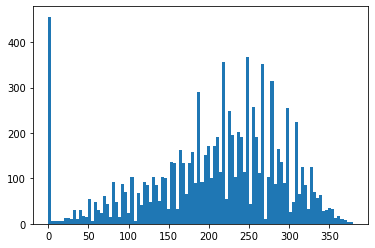

In [191]:
plt.hist(targets, bins=100);

In [202]:
counts = np.unique(np.array(targets), return_counts=True)

In [210]:
class_weights = {key:val for key, val in zip(counts[0], counts[1])}
class_mean = np.mean(list(class_weights.values()))
class_weights = {key:(1 / val) * class_mean for key, val in zip(counts[0], counts[1])}

In [211]:
class_weights

{0: 0.8706140350877192,
 1: 0.2176535087719298,
 2: 0.11355835240274599,
 4: 15.671052631578947,
 5: 31.342105263157894,
 6: 15.671052631578947,
 7: 31.342105263157894,
 8: 15.671052631578947,
 9: 31.342105263157894,
 10: 15.671052631578947,
 11: 31.342105263157894,
 12: 10.44736842105263,
 14: 31.342105263157894,
 15: 15.671052631578947,
 16: 10.44736842105263,
 17: 10.44736842105263,
 19: 31.342105263157894,
 20: 15.671052631578947,
 21: 10.44736842105263,
 22: 5.223684210526315,
 24: 31.342105263157894,
 25: 15.671052631578947,
 26: 3.1342105263157896,
 27: 15.671052631578947,
 28: 3.9177631578947367,
 30: 31.342105263157894,
 31: 10.44736842105263,
 32: 5.223684210526315,
 33: 1.5671052631578948,
 34: 31.342105263157894,
 35: 15.671052631578947,
 36: 3.9177631578947367,
 38: 31.342105263157894,
 39: 10.44736842105263,
 40: 5.223684210526315,
 41: 1.5671052631578948,
 42: 31.342105263157894,
 43: 15.671052631578947,
 44: 2.238721804511278,
 46: 15.671052631578947,
 47: 6.26842105263

In [185]:
from tensorflow.keras.optimizers import RMSprop

opt = RMSprop(learning_rate=0.01)

def initialize_model():
    model = Sequential()
    
    model.add(LSTM(512, activation='tanh', input_shape=X.shape[1:], return_sequences=True))
    model.add(Dropout(0.1))
    model.add(LSTM(256, activation='tanh'))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(y.shape[1], activation='softmax'))
    
    model.compile(loss='sparse_categorical_crossentropy', optimizer=opt)
    
    return model

In [186]:
model = initialize_model()
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 10, 512)           1052672   
_________________________________________________________________
dropout_6 (Dropout)          (None, 10, 512)           0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 256)               787456    
_________________________________________________________________
dense_6 (Dense)              (None, 256)               65792     
_________________________________________________________________
dropout_7 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 380)               97660     
Total params: 2,003,580
Trainable params: 2,003,580
Non-trainable params: 0
____________________________________________

In [212]:
es = EarlyStopping(patience=5, restore_best_weights=True)

history = model.fit(X, np.array(targets), validation_split=0.2, batch_size=32, epochs=500, callbacks=[es], verbose=1, class_weight=class_weights)

ValueError: Expected `class_weight` to be a dict with keys from 0 to one less than the number of classes, found {0: 0.8706140350877192, 1: 0.2176535087719298, 2: 0.11355835240274599, 4: 15.671052631578947, 5: 31.342105263157894, 6: 15.671052631578947, 7: 31.342105263157894, 8: 15.671052631578947, 9: 31.342105263157894, 10: 15.671052631578947, 11: 31.342105263157894, 12: 10.44736842105263, 14: 31.342105263157894, 15: 15.671052631578947, 16: 10.44736842105263, 17: 10.44736842105263, 19: 31.342105263157894, 20: 15.671052631578947, 21: 10.44736842105263, 22: 5.223684210526315, 24: 31.342105263157894, 25: 15.671052631578947, 26: 3.1342105263157896, 27: 15.671052631578947, 28: 3.9177631578947367, 30: 31.342105263157894, 31: 10.44736842105263, 32: 5.223684210526315, 33: 1.5671052631578948, 34: 31.342105263157894, 35: 15.671052631578947, 36: 3.9177631578947367, 38: 31.342105263157894, 39: 10.44736842105263, 40: 5.223684210526315, 41: 1.5671052631578948, 42: 31.342105263157894, 43: 15.671052631578947, 44: 2.238721804511278, 46: 15.671052631578947, 47: 6.268421052631579, 49: 3.9177631578947367, 50: 0.8954887218045112, 51: 31.342105263157894, 52: 15.671052631578947, 53: 1.9588815789473684, 55: 15.671052631578947, 56: 6.268421052631579, 58: 3.9177631578947367, 59: 0.824792243767313, 60: 31.342105263157894, 61: 15.671052631578947, 62: 1.119360902255639, 65: 15.671052631578947, 66: 3.4824561403508767, 68: 2.410931174089069, 69: 15.671052631578947, 70: 0.5498614958448753, 71: 10.44736842105263, 73: 15.671052631578947, 74: 0.7644415917843389, 77: 15.671052631578947, 78: 2.238721804511278, 80: 2.238721804511278, 81: 15.671052631578947, 82: 0.4477443609022556, 83: 6.268421052631579, 85: 15.671052631578947, 86: 0.6964912280701755, 89: 15.671052631578947, 90: 2.238721804511278, 92: 2.238721804511278, 93: 15.671052631578947, 94: 0.4414381022979985, 95: 6.268421052631579, 97: 15.671052631578947, 98: 0.5055178268251274, 100: 15.671052631578947, 101: 15.671052631578947, 102: 1.5671052631578948, 104: 2.0894736842105264, 105: 7.8355263157894735, 106: 0.37761572606214333, 107: 6.268421052631579, 109: 15.671052631578947, 110: 0.49749373433583954, 112: 10.44736842105263, 113: 15.671052631578947, 114: 1.5671052631578948, 116: 1.8436532507739938, 117: 7.8355263157894735, 118: 0.3731203007518797, 119: 6.268421052631579, 121: 15.671052631578947, 122: 0.39673550966022647, 123: 31.342105263157894, 124: 10.44736842105263, 125: 15.671052631578947, 126: 1.362700228832952, 128: 1.3059210526315788, 129: 6.268421052631579, 130: 0.340675057208238, 131: 6.268421052631579, 133: 15.671052631578947, 134: 0.39673550966022647, 135: 31.342105263157894, 136: 10.44736842105263, 137: 15.671052631578947, 138: 1.362700228832952, 140: 1.2536842105263157, 141: 6.268421052631579, 142: 0.340675057208238, 143: 6.268421052631579, 145: 15.671052631578947, 146: 0.3264802631578947, 147: 15.671052631578947, 148: 10.44736842105263, 149: 15.671052631578947, 150: 1.119360902255639, 152: 1.1608187134502923, 153: 5.223684210526315, 154: 0.31658692185007975, 155: 6.268421052631579, 157: 0.25073684210526315, 158: 6.268421052631579, 159: 10.44736842105263, 160: 31.342105263157894, 161: 1.0110356536502547, 163: 0.9497607655502392, 164: 3.9177631578947367, 165: 0.27493074792243766, 166: 4.477443609022556, 168: 0.24874686716791977, 169: 6.268421052631579, 170: 10.44736842105263, 171: 31.342105263157894, 172: 0.9794407894736842, 174: 0.9497607655502392, 175: 3.9177631578947367, 176: 0.26561106155218556, 177: 4.477443609022556, 179: 0.21034969975273754, 180: 5.223684210526315, 181: 10.44736842105263, 182: 0.8036437246963563, 183: 0.7462406015037594, 184: 3.4824561403508767, 186: 0.2321637426900585, 187: 4.477443609022556, 189: 0.2117709815078236, 190: 5.223684210526315, 191: 7.8355263157894735, 192: 0.8036437246963563, 193: 0.7288861689106487, 194: 3.4824561403508767, 196: 0.2321637426900585, 197: 4.477443609022556, 199: 0.19111039794608473, 200: 4.477443609022556, 201: 5.223684210526315, 203: 0.7288861689106487, 204: 0.6027327935222673, 205: 3.4824561403508767, 207: 0.20091093117408906, 208: 4.477443609022556, 209: 0.17509556012937372, 210: 4.477443609022556, 211: 5.223684210526315, 213: 0.7462406015037594, 214: 0.5312221231043711, 215: 2.6118421052631575, 217: 0.17909774436090226, 218: 6.268421052631579, 219: 0.17707404103479035, 220: 4.477443609022556, 221: 5.223684210526315, 223: 0.7462406015037594, 224: 0.5223684210526316, 225: 2.6118421052631575, 227: 0.17808014354066987, 228: 6.268421052631579, 229: 0.17707404103479035, 230: 4.477443609022556, 231: 5.223684210526315, 233: 0.8470839260312945, 234: 0.4748803827751196, 235: 2.849282296650718, 237: 0.170337528604119, 238: 4.477443609022556, 239: 0.17509556012937372, 240: 4.477443609022556, 241: 6.268421052631579, 243: 0.824792243767313, 244: 0.4897203947368421, 245: 2.849282296650718, 247: 0.1712683347713546, 248: 4.477443609022556, 249: 0.1832871652816251, 250: 5.223684210526315, 251: 6.268421052631579, 253: 0.824792243767313, 254: 0.5055178268251274, 255: 2.849282296650718, 257: 0.16941678520625889, 258: 3.9177631578947367, 259: 0.18222154222766218, 260: 5.223684210526315, 261: 6.268421052631579, 263: 0.8036437246963563, 264: 0.5138050043140638, 265: 2.849282296650718, 267: 0.16941678520625889, 268: 3.9177631578947367, 269: 0.1971201588877855, 270: 6.268421052631579, 271: 6.268421052631579, 273: 0.9218266253869969, 274: 0.5312221231043711, 275: 3.1342105263157896, 277: 0.18116823851536354, 278: 3.4824561403508767, 279: 0.239252711932503, 280: 15.671052631578947, 281: 6.268421052631579, 283: 1.0807622504537204, 284: 0.5913604766633564, 285: 3.9177631578947367, 287: 0.2075636110142907, 288: 5.223684210526315, 289: 0.24109311740890688, 290: 15.671052631578947, 291: 6.268421052631579, 293: 1.119360902255639, 294: 0.5913604766633564, 295: 3.9177631578947367, 297: 0.2117709815078236, 298: 5.223684210526315, 299: 0.30727554179566563, 300: 31.342105263157894, 301: 6.268421052631579, 303: 1.649584487534626, 304: 0.7462406015037594, 305: 4.477443609022556, 307: 0.2701905626134301, 308: 5.223684210526315, 309: 0.3103178738926524, 310: 31.342105263157894, 311: 7.8355263157894735, 313: 1.649584487534626, 314: 0.7462406015037594, 315: 4.477443609022556, 317: 0.27736376339077784, 318: 5.223684210526315, 319: 0.42934390771449166, 321: 15.671052631578947, 322: 2.849282296650718, 323: 1.119360902255639, 324: 6.268421052631579, 326: 0.42934390771449166, 327: 7.8355263157894735, 328: 0.6964912280701755, 329: 15.671052631578947, 330: 4.477443609022556, 331: 1.5671052631578948, 332: 15.671052631578947, 333: 0.7644415917843389, 334: 7.8355263157894735, 335: 0.7288861689106487, 336: 15.671052631578947, 337: 4.477443609022556, 338: 1.649584487534626, 339: 15.671052631578947, 340: 0.8036437246963563, 341: 7.8355263157894735, 342: 1.3059210526315788, 344: 6.268421052631579, 345: 3.1342105263157896, 346: 31.342105263157894, 347: 1.7412280701754383, 348: 15.671052631578947, 349: 1.4924812030075187, 351: 7.8355263157894735, 352: 3.1342105263157896, 353: 31.342105263157894, 354: 1.7412280701754383, 355: 15.671052631578947, 356: 2.6118421052631575, 357: 31.342105263157894, 358: 6.268421052631579, 360: 5.223684210526315, 361: 31.342105263157894, 362: 2.849282296650718, 363: 6.268421052631579, 365: 5.223684210526315, 366: 31.342105263157894, 367: 7.8355263157894735, 368: 6.268421052631579, 370: 7.8355263157894735, 372: 31.342105263157894, 373: 31.342105263157894, 374: 31.342105263157894, 376: 31.342105263157894, 377: 31.342105263157894, 379: 31.342105263157894}

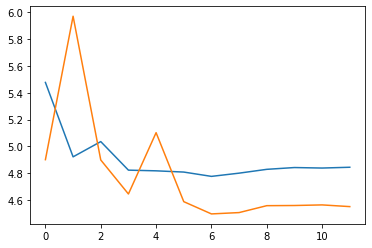

In [143]:
plt.plot(history.epoch, history.history['loss'])
plt.plot(history.epoch, history.history['val_loss'])

In [144]:
note_count = 10
Music = ""
notes_generated = []
for i in range(note_count):
    sample = X[0].reshape(1, length, 1)
    prediction = model.predict(sample, verbose=1)[0]
    prediction = np.log(prediction) / 1.0  # diversity?
    exp_preds = np.exp(prediction)
    prediction = exp_preds / np.sum(exp_preds)
    index = np.argmax(prediction)
    index_N = index / float(L_symb)
    notes_generated.append(index)
    Music = [reverse_mapping[char] for char in notes_generated]
    seed = np.insert(sample[0], len(sample[0]), index_N)
    sample = sample[1:]

1/1 [==============================] - 0s 29ms/step


In [145]:
Music

['63-8',
 '63-8',
 '63-8',
 '63-8',
 '63-8',
 '63-8',
 '63-8',
 '63-8',
 '63-8',
 '63-8']

In [24]:
corpus = []
for df in all_csv_dfs:
    for i, val in df.iterrows():
        pitch_dur = str(val.pitch_norm) + '-' + str(val.duration)
        corpus.append(pitch_dur)

In [29]:
count_num = collections.Counter(corpus)
print("Total notes in dataset:", len(corpus))
print("Total unique note / duration pairs in corpus:", len(count_num))

Total notes in dataset: 1364
Total unique note / duration pairs in corpus: 152


In [33]:
# Exploring the notes dictionary
Notes = list(count_num.keys())
Recurrence = list(count_num.values())

# Average recurrence for a note in Corpus
def Average(lst):
    return sum(lst) / len(lst)
print("Average recurrence for a note in Corpus:", Average(Recurrence))
print("Most frequent note in Corpus appeared:", max(Recurrence), "times")
print("Least frequent note in Corpus appeared:", min(Recurrence), "time")

Average recurrence for a note in Corpus: 8.973684210526315
Most frequent note in Corpus appeared: 63 times
Least frequent note in Corpus appeared: 1 time


In [34]:
# getting a list of rare notes
rare_note = []
for index, (key, value) in enumerate(count_num.items()):
    if value < 3:
        m = key
        rare_note.append(m)
        
print("Total number of notes that occur less than 3 times:", len(rare_note))

Total number of notes that occur less than 3 times: 65


In [37]:
# Eliminating the rare notes
for element in corpus:
    if element in rare_note:
        corpus.remove(element)
        
print("Length of Corpus after elimination of rare notes:", len(corpus))

Length of Corpus after elimination of rare notes: 1274


**Data preprocessing**

In [38]:
# Storing all the unique characters present in the corpus to buid a mapping dict.
symb = sorted(list(set(corpus)))

L_corpus = len(corpus)  # length of corpus
L_symb = len(symb)  # length of total unique characters

# Building dictionary to access the vocabulary from indices and vice versa
mapping = dict((c, i) for i, c in enumerate(symb))
reverse_mapping = dict((i, c) for i, c in enumerate(symb))

print("Total number of characters:", L_corpus)
print("Number of unique characters:", L_symb)

Total number of characters: 1274
Number of unique characters: 88


**Encoding and Splitting the Corpus as Labels and Targets**

In [40]:
# Splitting the corpus in equal length of strings and output target
length = 10
features = []
targets = []
for i in range(0, L_corpus - length, 1):
    feature = corpus[i:i + length]
    target = corpus[i + length]
    features.append([mapping[j] for j in feature])
    targets.append(mapping[target])
    
L_datapoints = len(targets)
print("Total number of sequences in the corpus:", L_datapoints)

Total number of sequences in the corpus: 1264


In [44]:
from tensorflow.keras.utils import to_categorical

# reshape X and normalize
X = (np.reshape(features, (L_datapoints, length, 1)))/ float(L_symb)
# one hot encode the output variable
y = to_categorical(targets)

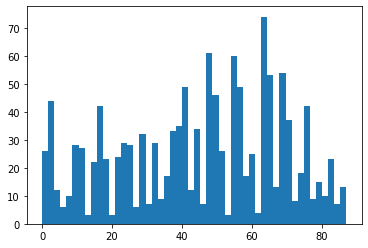

In [71]:
plt.hist(targets, bins=50);

**Model Building**

In [51]:
from tensorflow.keras.optimizers import RMSprop

opt = RMSprop(learning_rate=0.01)

def initialize_model():
    model = Sequential()
    
    model.add(LSTM(512, input_shape=X.shape[1:], return_sequences=True))
    model.add(Dropout(0.1))
    model.add(LSTM(256))
    model.add(Dense(256))
    model.add(Dropout(0.1))
    model.add(Dense(y.shape[1], activation='softmax'))
    
    model.compile(loss='categorical_crossentropy', optimizer=opt)
    
    return model

In [52]:
model = initialize_model()
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 10, 512)           1052672   
_________________________________________________________________
dropout_2 (Dropout)          (None, 10, 512)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 256)               787456    
_________________________________________________________________
dense_2 (Dense)              (None, 256)               65792     
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 88)                22616     
Total params: 1,928,536
Trainable params: 1,928,536
Non-trainable params: 0
____________________________________________

In [54]:
es = EarlyStopping(patience=5, restore_best_weights=True)

history = model.fit(X, y, validation_split=0.2, batch_size=32, epochs=500, , callbacks=[es], verbose=1,
                   #class_weight={class_labels: weights - inverse of occurences}
                   )

2022-03-04 09:50:14.169446: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/500
32/32 [==============================] - 17s 290ms/step - loss: 9.3999 - val_loss: 5.2953
Epoch 2/500
32/32 [==============================] - 8s 257ms/step - loss: 5.2493 - val_loss: 5.3932
Epoch 3/500
32/32 [==============================] - 8s 264ms/step - loss: 4.9461 - val_loss: 4.4797
Epoch 4/500
32/32 [==============================] - 8s 262ms/step - loss: 4.6033 - val_loss: 4.4442
Epoch 5/500
32/32 [==============================] - 8s 255ms/step - loss: 4.4204 - val_loss: 4.5704
Epoch 6/500
32/32 [==============================] - 8s 237ms/step - loss: 4.3276 - val_loss: 4.3611
Epoch 7/500
32/32 [==============================] - 8s 266ms/step - loss: 4.2357 - val_loss: 4.2884
Epoch 8/500
32/32 [==============================] - 8s 249ms/step - loss: 4.2282 - val_loss: 4.3043
Epoch 9/500
32/32 [==============================] - 8s 256ms/step - loss: 4.2059 - val_loss: 4.1929
Epoch 10/500
32/32 [==============================] - 8s 250ms/step - loss: 4.1762 - val_l

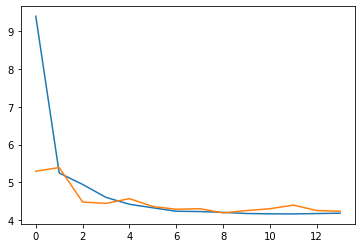

In [56]:
plt.plot(history.epoch, history.history['loss'])
plt.plot(history.epoch, history.history['val_loss'])

In [64]:
note_count = 10
Music = ""
notes_generated = []
for i in range(note_count):
    sample = X[0].reshape(1, length, 1)
    prediction = model.predict(sample, verbose=1)[0]
    prediction = np.log(prediction) / 1.0  # diversity?
    exp_preds = np.exp(prediction)
    prediction = exp_preds / np.sum(exp_preds)
    index = np.argmax(prediction)
    index_N = index / float(L_symb)
    notes_generated.append(index)
    Music = [reverse_mapping[char] for char in notes_generated]
    seed = np.insert(sample[0], len(sample[0]), index_N)
    sample = sample[1:]

1/1 [==============================] - 0s 33ms/step


In [66]:
Music

['72-8',
 '72-8',
 '72-8',
 '72-8',
 '72-8',
 '72-8',
 '72-8',
 '72-8',
 '72-8',
 '72-8']

### Create midi file

In [ ]:
def notes_to_midi(
    notes: pd.DataFrame,
    instrument_name: str,
    velocity: int = 100 # note loudness
) -> pretty_midi.PrettyMIDI:
    
    pm = pretty_midi.PrettyMIDI()
    instrument = pretty_midi.Instrument(
        program=pretty_midi.instrument_name_to_program(
            instrument_name))
    
    prev_start = 0
    for i, note in notes.iterrows():
        start = float(prev_start)
        end = float(prev_start + note['dur(s)'])
        if note['note_name'] == 'r':
            start += float(note['dur(s)'])
            prev_start = start
        else:
            note = pretty_midi.Note(
                velocity=velocity,
                pitch=note.pitch_norm,
#                 pitch=int(pretty_midi.note_name_to_number(note['note_name'])),
                start=start,
                end=end
            )
            instrument.notes.append(note)
            prev_start = end
            
    pm.instruments.append(instrument)
    return pm

In [ ]:
instrument_name = 'Acoustic Guitar (nylon)'

all_midis = []
for df in all_csv_dfs:
    pm = notes_to_midi(df, instrument_name)
    all_midis.append(pm)

In [ ]:
instrument = all_midis[0].instruments[0]
instrument.notes

### Playback the midi

In [ ]:
_SAMPLING_RATE = 16000

def display_audio(pm: pretty_midi.PrettyMIDI):
    waveform = pm.fluidsynth(fs=_SAMPLING_RATE)
    return display.Audio(waveform, rate=_SAMPLING_RATE)

In [ ]:
# instrument_name = 'Electric Piano 1'
instrument_name = 'Acoustic Guitar (nylon)'
out_file = 'example.midi'

example_pm = notes_to_midi(all_csv_dfs[10], instrument_name)

In [ ]:
#display_audio(example_pm)

### Create dataframe from midi

In [ ]:
filenames[45]

In [ ]:
instrument = example_pm.instruments[0]
instrument.notes

In [ ]:
def midi_to_notes(midi: pretty_midi.PrettyMIDI()) -> pd.DataFrame:
#     pm = pretty_midi.PrettyMIDI(midi_file)
    instrument = midi.instruments[0]
    notes = collections.defaultdict(list)
    
    # Sort the notes by start time
    sorted_notes = sorted(instrument.notes, key=lambda note: note.start)
    prev_start = sorted_notes[0].start
    
    for note in sorted_notes:
        start = note.start
        end = note.end
        notes['pitch'].append(note.pitch)
        notes['start'].append(start)
        notes['end'].append(end)
        notes['step'].append(start-prev_start)
        notes['duration'].append(end - start)
        prev_start = start
        
    return pd.DataFrame({name: np.array(value) for name, value in notes.items()})

In [ ]:
all_midi_dfs = []

for midi in all_midis:
    midi_df = midi_to_notes(midi)
    all_midi_dfs.append(midi_df)

In [ ]:
all_midi_dfs[45].head()

In [ ]:
max_pitch_list = []
min_pitch_list = []
pitch_list = []
for midi in all_midi_dfs:
    max_pitch_list.append(midi.pitch.max())
    min_pitch_list.append(midi.pitch.min())
    for pitch in midi.pitch:
        if pitch not in pitch_list:
            pitch_list.append(pitch)

In [ ]:
pitch_list.sort()
print(f"highest note: {max(max_pitch_list)} ({pretty_midi.note_number_to_name(max(max_pitch_list))})")
print(f"lowest note:, {min(min_pitch_list)} ({pretty_midi.note_number_to_name(min(min_pitch_list))})")
print('number of different notes:', len(pitch_list))

### Create slices

In [ ]:
slice_length = 10
X = []
y = []

for midi in all_midi_dfs:
    df_len = len(midi)
    last_possible_index = df_len - (slice_length)
    for i in range(last_possible_index):
        X.append(midi.loc[i:i+slice_length - 1])
        y.append(midi.loc[i+slice_length])

In [ ]:
# num_slices_per_midi = 5
# slice_length = 4
# X = []
# y = []

# for midi in all_midi_dfs:
#     df_len = len(midi)
#     last_possible_ind = df_len - (slice_length + 1)
#     slice_ind = np.random.choice(last_possible_ind, num_slices_per_midi, replace=False)
#     for i in slice_ind:
#         X.append(midi.loc[i:i+(slice_length - 1)])
#         y.append(midi.loc[i+slice_length])


In [ ]:
X[0].values

**transpose notes to all 12 keys**

In [ ]:
X_np = []

for seq in X:    
    for i in range(-6, 6):
        transposer = np.array([[i, 0, 0, 0, 0]])
        X_np.append(seq.values + transposer)

In [ ]:
y_np = []

for seq in y:
    for i in range(-6, 6):
        transposer = np.array([[i, 0, 0, 0, 0]])
        y_np.append(seq.values + transposer)

In [ ]:
print(len(X_np))
X_np[0], X_np[1]

In [ ]:
print(len(y_np))
y_np[0]

**create 3d tensors for model**

In [ ]:
X_seq = []
for slice in X_np:
    X_seq.append(np.delete(slice, [1,2], axis=1))

X_3d = np.stack(X_seq)

y_seq = []
for slice in y_np:
    y_seq.append(np.delete(slice, [1,2]))

y_2d = np.stack(y_seq)

In [ ]:
print(X_3d.shape)
print(y_2d.shape)

### Simple model

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

def initialize_model():
    model = Sequential()
    
    model.add(layers.LSTM(256, activation='tanh', input_shape=X_3d.shape[1:], return_sequences=True))
    
    model.add(layers.Dropout(rate=0.1))
    model.add(layers.LSTM(32, activation='tanh'))
    model.add(layers.Dense(32, activation='relu'))
    
    model.add(layers.Dropout(rate=0.2))
    model.add(layers.Dense(3, activation='linear'))
    
    model.compile(loss='mse', optimizer='rmsprop')
    
    return model

In [ ]:
model = initialize_model()
model.summary()

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping#, ModelCheckpoint

filepath = '../models.{epoch:02d}-{val_loss:.2f}.h5'

# Trains the model
es = [EarlyStopping(patience=10, restore_best_weights=True),
      #ModelCheckpoint(filepath=filepath, save_best_only=True)
     ]

model = initialize_model()
history = model.fit(X_3d, y_2d, validation_split=0.3, batch_size=16, epochs=500, verbose=1, callbacks=[es])

In [ ]:
plt.plot(history.epoch, history.history['loss'])
plt.plot(history.epoch, history.history['val_loss'])

In [ ]:
X_test = tf.expand_dims(X_3d[0], 0)

y_pred = model.predict(X_test)

y_pred

### Generate Notes

In [ ]:
np.mean(X_3d[100][:,2])

In [ ]:
number_predictions = 20

input_notes = X_3d[100]

generated_notes = []
prev_start = 0
for i in range(number_predictions):
    inputs = tf.expand_dims(input_notes, 0)
    y_pred = model.predict(inputs)
    pitch = int(y_pred[0][0])
    step = y_pred[0][1]
    duration = y_pred[0][2]
    start = prev_start + step
    end = start + duration
    input_note = (pitch, step, duration)
    generated_notes.append((*input_note, start, end))
    input_notes = np.delete(input_notes, 0, axis=0)
    input_notes = np.append(input_notes, np.expand_dims(input_note, 0), axis=0)
    prev_start = start
    

In [ ]:
gn_columns = ['pitch', 'step', 'duration', 'start', 'end']
generated_notes = pd.DataFrame(generated_notes, columns=gn_columns)

generated_notes

### (old) stack all dfs together

In [ ]:
midi_dfs_stack = np.vstack(all_midi_dfs)

num_slices = 200
slice_length = 30
X = []
y = []

array_len = midi_dfs_stack.shape[0]
last_possible_ind = array_len - (slice_length + 1)
slice_ind = np.random.choice(last_possible_ind, num_slices, replace=False)   
    
for i in slice_ind:
    X.append(midi_dfs_stack[i:i+(slice_length - 1)])
    y.append(midi_dfs_stack[i+slice_length])

In [ ]:
X[0]

In [ ]:
X_seq = []
for sequence in X:
    X_seq.append(np.delete(sequence, [1,2], axis=1))

X_3d = np.stack(X_seq)

y_seq = []
for sequence in y:
    y_seq.append(np.delete(sequence, [1,2]))

y_2d = np.stack(y_seq)

In [ ]:
print(X_3d.shape)
print(y_2d.shape)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

def initialize_model():
    model = Sequential()
    model.add(layers.LSTM(units=len(pitch_list), activation='tanh', kernel_regularizer='l1', input_shape=X_3d.shape[1:]))
    model.add(layers.Dense(3, activation='linear'))
    
    model.compile(loss='mse', optimizer='rmsprop')
    
    return model

In [ ]:
model.save('model.h5')

In [ ]:
from keras.models import load_model

In [ ]:
model = load_model('model.h5')

In [ ]:
model = initialize_model()
model.summary()

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

es = EarlyStopping(patience=20, restore_best_weights=True)

model = initialize_model()
history = model.fit(X_3d, y_2d, validation_split=0.3, batch_size=16, epochs=300, verbose=1, callbacks=[es])

In [ ]:
plt.plot(history.epoch, history.history['loss'])

In [ ]:
number_predictions = 20

input_notes = X_3d[0]

In [ ]:
X_3d[0]

In [ ]:
generated_notes = []
prev_start = 0
for i in range(number_predictions):
    inputs = tf.expand_dims(input_notes, 0)
    y_pred = model.predict(inputs)
    pitch = int(y_pred[0][0])
    step = y_pred[0][1]
    duration = y_pred[0][2]
    start = prev_start + step
    end = start + duration
    input_note = (pitch, step, duration)
    generated_notes.append((*input_note, start, end))
    input_notes = np.delete(input_notes, 0, axis=0)
    input_notes = np.append(input_notes, np.expand_dims(input_note, 0), axis=0)
    prev_start = start

In [ ]:
generated_notes = pd.DataFrame(generated_notes, columns=all_midi_dfs[0].columns)

generated_notes

In [ ]:
import joblib
joblib.dump(model, 'model')

In [ ]:
def midi_df_to_midi(
    notes: pd.DataFrame,
    instrument_name: str,
    velocity: int = 100 # note loudness
) -> pretty_midi.PrettyMIDI:
    
    pm = pretty_midi.PrettyMIDI()
    instrument = pretty_midi.Instrument(
        program=pretty_midi.instrument_name_to_program(
            instrument_name))
    
    prev_start = 0
    for i, note in notes.iterrows():
        start = float(prev_start + note['step'])
        end = float(start + note['duration'])
        note = pretty_midi.Note(
            velocity=velocity,
            pitch=int(note['pitch']),
            start=start,
            end=end,
        )
        instrument.notes.append(note)
        prev_start = start
        
    pm.instruments.append(instrument)
    return pm

In [ ]:
pm = midi_df_to_midi(generated_notes, instrument_name)
display_audio(pm)

### from RNN tutorial

In [ ]:
def mse_with_positive_pressure(y_true: tf.Tensor, y_pred: tf.Tensor):
    mse = (y_true -y_pred) ** 2
    positive_pressure = 10 * tf.maximum(-y_pred, 0.0)
    return tf.reduce_mean(mse + positive_pressure)

In [ ]:
input_shape = X_3d.shape[1:]
learning_rate = 0.005

inputs = tf.keras.Input(input_shape)
x = tf.keras.layers.LSTM(len(pitch_list))(inputs)

outputs = {
    'pitch': tf.keras.layers.Dense(len(pitch_list), name='pitch')(x),
    'step': tf.keras.layers.Dense(1, name='step')(x),
    'duration': tf.keras.layers.Dense(1, name='duration')(x),
}
                                   

model = tf.keras.Model(inputs, outputs)

loss = {
    'pitch': tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    'step': mse_with_positive_pressure,
    'duration': mse_with_positive_pressure,
}

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

model.compile(loss=loss, optimizer=optimizer)

model.summary()

In [ ]:
model.compile(
    loss=loss,
    loss_weights={
        'pitch': 0.05,
        'step': 1.0,
        'duration': 1.0
    },
    optimizer=optimizer,
)


In [ ]:
es = tf.keras.callbacks.EarlyStopping(
        monitor='loss',
        patience=5,
        verbose=1,
        restore_best_weights=True)

In [ ]:
%%time
epochs = 10

history = model.fit(
    X_3d,
    epochs=epochs,
    callbacks=[es],
)

### dataframes to tensorflow dataset

In [ ]:
key_order = ['pitch', 'step', 'duration']

midi_arrays = []
for df in all_midi_dfs:
    midi_arrays.append(np.stack([df[key] for key in key_order], axis=1))

In [ ]:
tf_stuff = []
for array in midi_arrays:
    tf_stuff.append(tf.data.Dataset.from_tensor_slices(array))

In [ ]:
list(tf_stuff[0].as_numpy_iterator())

### Useful code

In [ ]:
# df['dur(s)'] = df.duration.apply(compound_duration_to_seconds)

In [ ]:
# prev_start = 0
# start = []
# end = []
# for _ in df['dur(s)']:
#     start.append(prev_start)
#     end_time = prev_start + _
#     end.append(end_time)
#     prev_start = end_time

In [ ]:
# df['start'] = pd.Series(start)
# df['end'] = pd.Series(end)
# df['pitch'] = df['note_name'].apply(lambda x: pretty_midi.note_name_to_number(x))